In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Domik Dataset

In [3]:
class DomikDataset(Dataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__()
        self.house_width = 0.6
        self.house_height = 0.7
        self.roof_height = 0.3
        
        self.points, self.targets = self._generate(dataset_size, noise)

    def _left_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 - self.house_width) / 2) / \
            (0.5 - (1 - self.house_width) / 2)
        k =  2 * (self.house_height - b) / (1 - self.house_width)
        return k * point[0] + b >= point[1]

    def _right_roof(self, point):
        b = (0.5 * self.house_height - (self.house_height + self.roof_height) * (1 + self.house_width) / 2) / \
            (0.5 - (1 + self.house_width) / 2)
        k = 2 * (self.house_height - b) / (1 + self.house_width)
        return k * point[0] + b >= point[1]
    
    
    def _generate(self, size, noise):
        points = [[random.random(), random.random()] for i in range(size)]

        targets = []
        for point in points:
            if (1 - self.house_width) / 2 <= point[0] <= (1 + self.house_width) / 2 and \
                self._left_roof(point) and self._right_roof(point):   
                inside = 1.
            else:
                inside = 0.

            if random.random() < noise:
                inside = 1. - inside

            targets.append(torch.tensor([inside], device=device, dtype=torch.int64))

        return points, targets
    
    def show(self, dividing_criterion=lambda s: 1 if s > 0.5 else 0):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []

        for sample in self:
            point, target = sample
            if dividing_criterion(target):
                domik_x.append(point[0])
                domik_y.append(point[1])
            else: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.')

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
               
        sample = (torch.tensor(self.points[idx], device=device), self.targets[idx])

        return sample

# Train function

In [4]:
def train(network, train_dataset, epochs, criterion, optimizer):
    loss_epochs = []
    for idx in range(epochs):
        loss_samples = []
        for sample in train_dataset:
            optimizer.zero_grad()   # zero the gradient buffers
            point, target = sample
            output = network(point)
            if len(output.size()) == 1:
                output = output.unsqueeze(0)
            # print(point, output, target)
            loss = criterion(output, target.to(device))
            loss.backward()
            loss_samples.append(loss.data.numpy())
            optimizer.step()    # Does the update

        loss_samples_mean = float(sum(loss_samples)) / len (loss_samples)
        print(f"Epoch {idx: >8} Loss: {loss_samples_mean}")
        loss_epochs.append(loss_samples_mean)

    plt.plot(loss_epochs)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show() 

# Test function

In [5]:
def test(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            # print(target, output)
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else:
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

# First steps

## Dataset

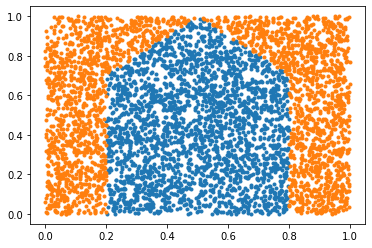

In [6]:
DATASET_SIZE = 5000
domik = DomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=1)

# plotting
domik.show()

In [7]:
domik[0:3]

(tensor([[0.5539, 0.0670],
         [0.8639, 0.6893],
         [0.7223, 0.6016]]), [tensor([1]), tensor([0]), tensor([1])])

## Net

In [8]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 2)

    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
)


In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.5851732322461903
Epoch        1 Loss: 0.4073840587502811
Epoch        2 Loss: 0.3325668042653531
Epoch        3 Loss: 0.20723808002369332
Epoch        4 Loss: 0.16940715588505337
Epoch        5 Loss: 0.14925834200318278
Epoch        6 Loss: 0.13607056780923177
Epoch        7 Loss: 0.12620396676019555
Epoch        8 Loss: 0.11838219465935501
Epoch        9 Loss: 0.11162334985586153
Epoch       10 Loss: 0.1049967874693861
Epoch       11 Loss: 0.09830755931431093
Epoch       12 Loss: 0.09237564273087952
Epoch       13 Loss: 0.08768784110110324
Epoch       14 Loss: 0.08362826187876081
Epoch       15 Loss: 0.07998623569688511
Epoch       16 Loss: 0.07679911257800089
Epoch       17 Loss: 0.07401535307319498
Epoch       18 Loss: 0.07151605276109887
Epoch       19 Loss: 0.06923316401046661


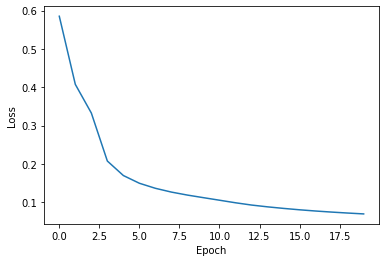

In [ ]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.001))

## Test

Accuracy of the network on the 25000 test samples: 98.82


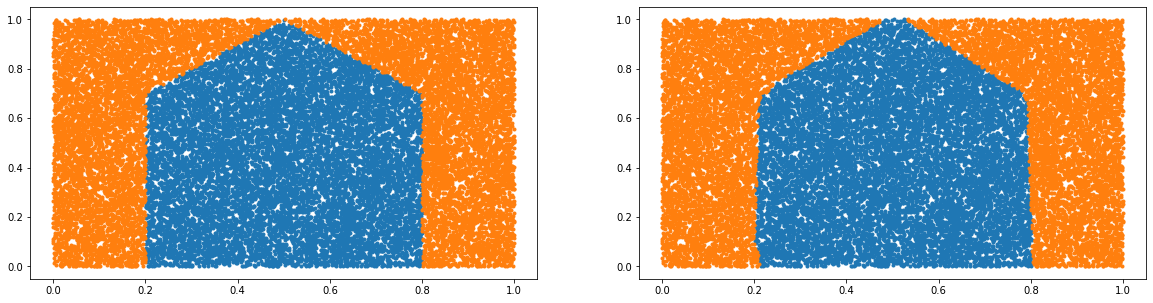

In [ ]:
test_dataset = DomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset)

# Domik dataset for multi classes

In [10]:
class MultiClassDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def show(self, dividing_criterion=lambda s: s[0] > s[1]):
        #super().show(dividing_criterion)
        super().show()
        
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, target in enumerate(targets):
            targets[i] = targets[i].item()
        targets = torch.LongTensor(targets)
        return points, targets

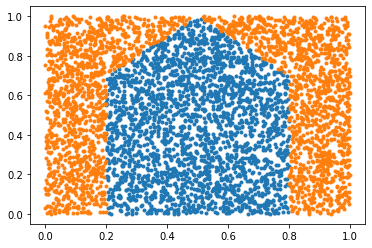

In [11]:
DATASET_SIZE = 5000
domik = MultiClassDomikDataset(DATASET_SIZE)

data = DataLoader(domik, batch_size=3)

# plotting
domik.show()

In [12]:
domik[0:3]

(tensor([[0.2340, 0.1238],
         [0.5111, 0.2027],
         [0.0316, 0.1590]]), tensor([1, 1, 0]))

## Net

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.6691931819349939
Epoch        1 Loss: 0.42464967139315374
Epoch        2 Loss: 0.30707610282131353
Epoch        3 Loss: 0.23610192470553884
Epoch        4 Loss: 0.23250397285625501
Epoch        5 Loss: 0.19977226268478607
Epoch        6 Loss: 0.19032023199130488
Epoch        7 Loss: 0.17092170231379328
Epoch        8 Loss: 0.1331502701522014
Epoch        9 Loss: 0.11363790367018935
Epoch       10 Loss: 0.10113190989065605
Epoch       11 Loss: 0.09304127210603189
Epoch       12 Loss: 0.08735494991263668
Epoch       13 Loss: 0.08327358044526836
Epoch       14 Loss: 0.07982257191983691
Epoch       15 Loss: 0.07699449583339468
Epoch       16 Loss: 0.074507343722064
Epoch       17 Loss: 0.07217768274089201
Epoch       18 Loss: 0.07008275812055297
Epoch       19 Loss: 0.06826420908576157


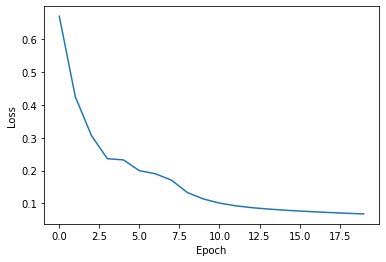

In [ ]:
EPOCHS_TO_TRAIN = 20
train(network=net, 
      train_dataset=data, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.1))

## Test

In [ ]:
def test_multiple(network, test_dataset, dividing_criterion):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (dividing_criterion(output) == dividing_criterion(target))

            # dividing dataset for plotting
            if dividing_criterion(output):
                
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.448


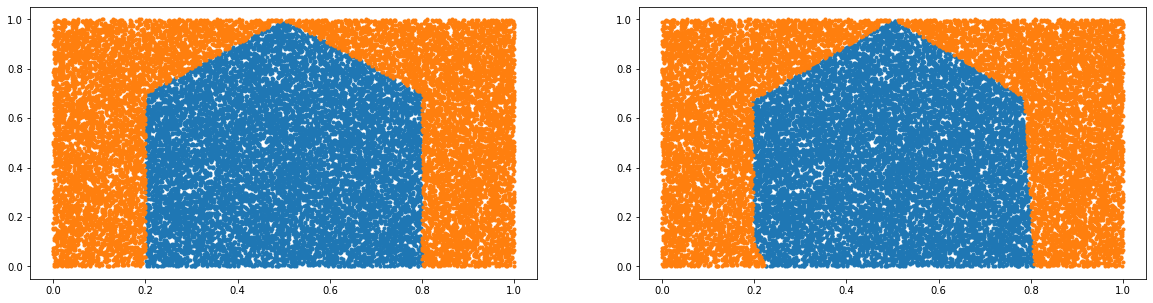

In [ ]:
test_dataset = MultiClassDomikDataset(DATASET_SIZE*5)
test_multiple(network=net, test_dataset=test_dataset, dividing_criterion=lambda s: 1 if s > 0.5 else 0)

# Domik with window dataset

In [84]:
class WindowedDomikDataset(DomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _window(self, point, width=0.3, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point):
                targets[i] = torch.tensor([0], device=device, dtype = torch.int64)
        return points, targets

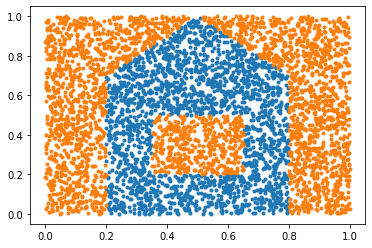

In [85]:
DATASET_SIZE = 5000
domik = WindowedDomikDataset(DATASET_SIZE)

# plotting
domik.show()

In [86]:
domik[0:3]

(tensor([[0.6883, 0.8476],
         [0.6070, 0.3660],
         [0.1142, 0.0645]]), [tensor([0]), tensor([0]), tensor([0])])

## Net

In [87]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        # x = F.leaky_relu(self.fc3(x))
        x = self.fc3(x)
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)


## Train

Epoch        0 Loss: 0.504502797718063
Epoch        1 Loss: 0.3382936094243077
Epoch        2 Loss: 0.25302653697987015
Epoch        3 Loss: 0.20105029893604273
Epoch        4 Loss: 0.1730387701767325
Epoch        5 Loss: 0.1550770633408647
Epoch        6 Loss: 0.14276815103173496
Epoch        7 Loss: 0.13459584818767092
Epoch        8 Loss: 0.1281042420998919
Epoch        9 Loss: 0.123006411534312
Epoch       10 Loss: 0.118440958404461
Epoch       11 Loss: 0.11497254946694922
Epoch       12 Loss: 0.11218592285997983
Epoch       13 Loss: 0.10851094929123023
Epoch       14 Loss: 0.1068443535243981


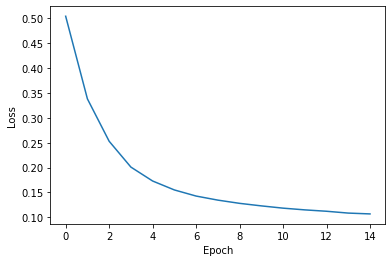

In [88]:
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.001))

Epoch        0 Loss: 0.07517703684758993
Epoch        1 Loss: 0.07167965915393001
Epoch        2 Loss: 0.07051424610788426
Epoch        3 Loss: 0.0696198792039158
Epoch        4 Loss: 0.06897459418636472
Epoch        5 Loss: 0.0683542602032521
Epoch        6 Loss: 0.06782807811220774
Epoch        7 Loss: 0.06725093284763146
Epoch        8 Loss: 0.06655358426597702
Epoch        9 Loss: 0.06610864278612803
Epoch       10 Loss: 0.06557081293589374
Epoch       11 Loss: 0.0650853414025108
Epoch       12 Loss: 0.0646101627681703
Epoch       13 Loss: 0.06420416028543291
Epoch       14 Loss: 0.06372133474742614


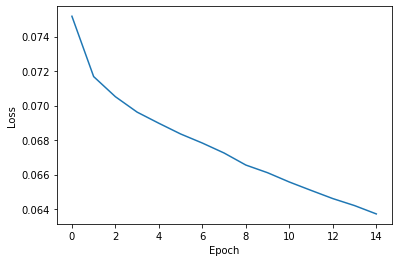

In [89]:
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.0001))

## Test

Accuracy of the network on the 25000 test samples: 98.028


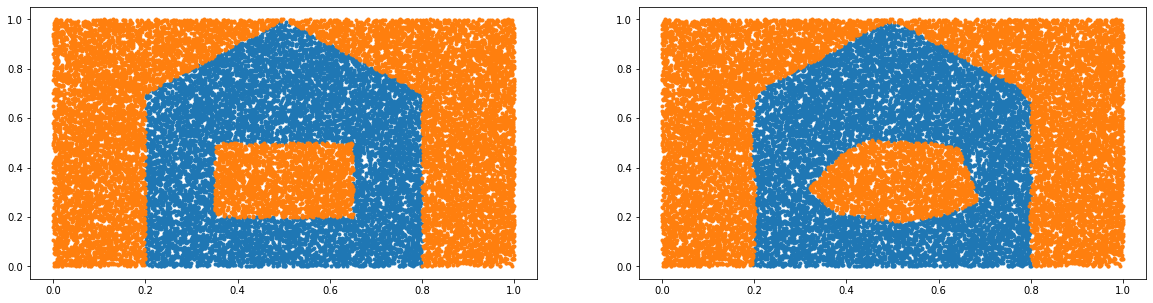

In [99]:
test_dataset = WindowedDomikDataset(DATASET_SIZE*5)
test(network=net, test_dataset=test_dataset)

# Homework

- [+] Обучить обычный домик (Accuracy >98%). 1 балл
- [+] Использовать для этого двухслойную сеть. 1 балл
- [+] Обучить домик с многоклассовой классификацией (зa тавтологию извините) (Accuracy >98%). 1 балл
- [+] Использовать для этого двухслойную сеть. 1 балл
- [+] Обучить домик с окошком (Accuracy >98%). 1 балл
- [+] Использовать для этого трехслойную сеть. 1 балл
- [+] Обучить домик с дверью и двумя окошками (Accuracy >98%). 2 балла
- [ ] Использовать для этого трехслойную сеть. 2 балла

#### ВАЖНО! ВЫБОРКУ УВЕЛИЧИВАТЬ НЕЛЬЗЯ!

Домашку выполняем в этой тетрадке и заливаем на гит, инструкция - https://youtu.be/lPcEQJiHDfg. Форма для сдачи - https://forms.gle/RJtnENVjGP6H5oPn6 \
Удачи!

## Domik with door and 2 windows dataset

In [33]:
class DoorDomikDataset(WindowedDomikDataset):
    def __init__(self, dataset_size, noise=0.0):
        super().__init__(dataset_size, noise)
        
    def _door(self, point, width=0.2, height=0.5, x=0.5):
        y = height / 2
        is_door = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_door
    
    def _window(self, point, width=0.1, height=0.3, x=0.5, y='middle'):
        if y == 'middle':
            y = self.house_height / 2
        is_window = x - width / 2 <= point[0] <= x + width / 2 and \
            y - height / 2 <= point[1] <= y + height / 2
        return is_window
    
    def show(self):
        domik_x = []
        domik_y = []
        nedomik_x = []
        nedomik_y = []
        door_x = []
        door_y = []

        for sample in self:
            point, target = sample
            if target == 1:
                domik_x.append(point[0])
                domik_y.append(point[1])
            elif target == 0: 
                nedomik_x.append(point[0])
                nedomik_y.append(point[1])
            else:
                door_x.append(point[0])
                door_y.append(point[1])

        plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y,'.', door_x, door_y, '.')
    def _generate(self, size, noise):
        points, targets = super()._generate(size, noise)
        for i, point in enumerate(points):
            if self._window(point, x=0.3):
                targets[i] = torch.tensor([0], device=device)
            if self._window(point, x=0.7):
                targets[i] = torch.tensor([0], device=device)
            if self._door(point):
                targets[i] = torch.tensor([2], device=device)
                
            # targets[i] = int(targets[i].item())
            targets[i] = targets[i].type(torch.LongTensor)
        return points, targets

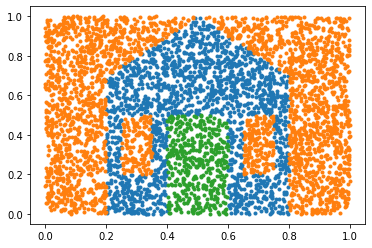

In [34]:
DATASET_SIZE = 5000

# generate dataset here
domik = DoorDomikDataset(DATASET_SIZE)

# plotting
domik.show()

In [35]:
domik[0:4]

(tensor([[0.7877, 0.5594],
         [0.3050, 0.8530],
         [0.0653, 0.5068],
         [0.7040, 0.1699]]),
 [tensor([1]), tensor([0]), tensor([0]), tensor([1])])

## Net

In [79]:
# create network here
class Net(nn.Module):

    def __init__(self, hidden_layers=3, hidden_size=20):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(2, hidden_size)
        self.fc = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(hidden_layers)])
        self.fc2 = nn.Linear(hidden_size, 3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        for linear in self.fc:
            x = F.leaky_relu(linear(x))
        # x = F.leaky_relu(self.fc2(x))
        x = self.fc2(x)
        return x

net = Net().float().to(device)
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
  )
  (fc2): Linear(in_features=20, out_features=3, bias=True)
)


## Train

Epoch        0 Loss: 0.5118555216694717
Epoch        1 Loss: 0.33801512643091686
Epoch        2 Loss: 0.2995670667403645
Epoch        3 Loss: 0.26338545787519213
Epoch        4 Loss: 0.23975480459036835
Epoch        5 Loss: 0.2171723091294253
Epoch        6 Loss: 0.18816721864918454
Epoch        7 Loss: 0.16773263521804438
Epoch        8 Loss: 0.1587650106486668
Epoch        9 Loss: 0.15365179114609437
Epoch       10 Loss: 0.1518694921951238
Epoch       11 Loss: 0.14894899516078833
Epoch       12 Loss: 0.14499386557633295
Epoch       13 Loss: 0.1408892487637724
Epoch       14 Loss: 0.1374469147619892


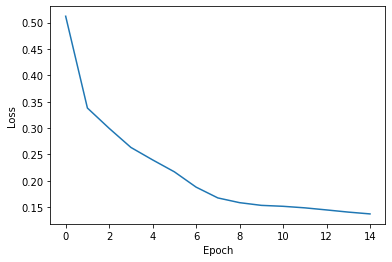

In [80]:
# train here
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.001))

Epoch        0 Loss: 0.07515532290042559
Epoch        1 Loss: 0.06424481513263448
Epoch        2 Loss: 0.06012182786046857
Epoch        3 Loss: 0.05771117990552597
Epoch        4 Loss: 0.05560139407941948
Epoch        5 Loss: 0.05400147361458621
Epoch        6 Loss: 0.052441934898000545
Epoch        7 Loss: 0.05123615229451965
Epoch        8 Loss: 0.05000250039075861
Epoch        9 Loss: 0.04880450738992337
Epoch       10 Loss: 0.04761746021263732
Epoch       11 Loss: 0.046780724682715026
Epoch       12 Loss: 0.04595908337163262
Epoch       13 Loss: 0.04515879891493384
Epoch       14 Loss: 0.04444698823697866


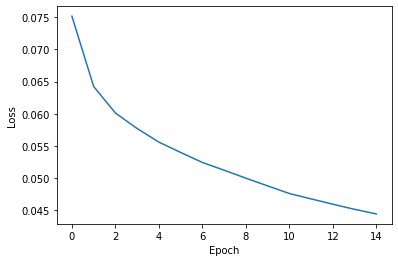

In [81]:
EPOCHS_TO_TRAIN = 15
train(network=net, 
      train_dataset=domik, 
      epochs=EPOCHS_TO_TRAIN, 
      criterion=nn.CrossEntropyLoss(), 
      optimizer=optim.Adam(net.parameters(), lr=0.0001))

## Test

In [43]:
def test_door_domik(network, test_dataset):
    domik_x = []
    domik_y = []
    nedomik_x = []
    nedomik_y = []
    door_x = []
    door_y = []

    correct = 0
    total = 0

    with torch.no_grad():
        for sample in test_dataset:
            inp, target = sample
            output = network(inp)
            _, output = torch.max(output, 0)
            total += 1
            correct += (output == target).sum().item()

            # dividing dataset for plotting
            if output == 1:
                domik_x.append(inp[0])
                domik_y.append(inp[1])
            elif output == 2:
                door_x.append(inp[0])
                door_y.append(inp[1])
            else: 
                nedomik_x.append(inp[0])
                nedomik_y.append(inp[1])
    
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    test_dataset.show()
    plt.subplot(122)
    plt.plot(domik_x, domik_y, '.', nedomik_x, nedomik_y, '.', door_x, door_y, '.')

    print(f'Accuracy of the network on the {total} test samples: {100 * correct / total}')

Accuracy of the network on the 25000 test samples: 98.288


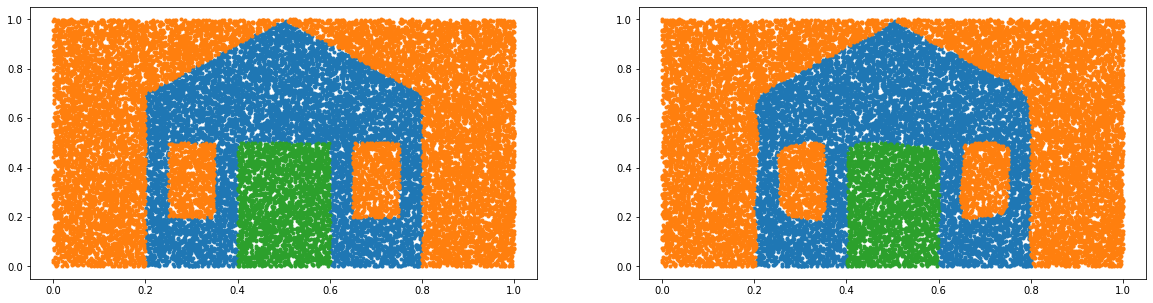

In [83]:
test_dataset = DoorDomikDataset(DATASET_SIZE*5)
test_door_domik(network=net, test_dataset=test_dataset)